In [ ]:
import os
import torch
from torch import nn
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from clipseg_model import CLIPSeg
from data.cub_parts_dataset import CUBPartsDataset, collate_fn

%load_ext autoreload
%autoreload 2

clip_seg = CLIPSeg()
state_dict = torch.load('PASCUB_runs/2024-04-08_23-44/checkpoint.pt', map_location='cpu')
clip_seg.load_state_dict(state_dict)

In [ ]:
dataset_test = CUBPartsDataset('datasets/PASCUB', split='test')
dataloader_test = DataLoader(dataset=dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)
dataloader_test_iter = iter(dataloader_test)

In [ ]:
# inference
batch = next(dataloader_test_iter)
clip_seg.eval()
with torch.no_grad():
    logits, outputs = clip_seg(batch)

In [ ]:
from clipseg.modeling_clipseg import CLIPSegDecoderLayer, CLIPSegDecoder


decoder_layer = nn.TransformerDecoderLayer(d_model=64, nhead=4, dim_feedforward=2048, activation='relu', norm_first=False)
# decoder = nn.TransformerDecoder(decoder_layer=..., num_layers=3, norm=...)

In [ ]:
x = torch.randn(32, 485, 64) # [bs*num_cond_emb, num_tokens, reduce_dim]
y = torch.randn(128, 485, 64) # [bs*num_cond_emb, num_tokens, reduce_dim]
decoder_layer(x, y).shape

In [ ]:
from clipseg.configuration_clipseg import CLIPSegConfig

config = CLIPSegConfig()

In [ ]:
config.vision_config.hidden_size, config.vision_config.intermediate_size

In [ ]:
clip_seg = CLIPSeg()

In [ ]:
a = torch.tensor([[i] * 10 for i in range(10)])
a

In [35]:
import numpy as np
from data.cub_dataset import DEFAULT_ATTR_INDICES

In [32]:
with open('concepts/CUB/concepts_v3.txt', 'r') as fp:
    concepts = fp.read().splitlines()

In [38]:
hierarchy = {
    'breast pattern': 'torso',
    'belly pattern': 'torso',
    'back pattern': 'torso',
    'underparts': 'torso',
    'upperparts': 'torso',
    'breast': 'torso',
    'belly': 'torso',
    'back': 'torso',
    'body': 'torso',
    'forehead': 'head',
    'throat': 'head',
    'crown': 'head',
    'nape': 'head',
    'head pattern': 'head',
    'under tail': 'tail',
    'upper tail': 'tail',
    'tail pattern': 'tail',
    'wing pattern': 'wing',

    'rounded-wings': 'rounded',
    'pointed-wings': 'pointed',
    'beak length about the same as head': 'long beak',
    'beak length shorter than head': 'short beak'
}

In [41]:
all_concepts = []
concepts = np.array(concepts)
for c in concepts[DEFAULT_ATTR_INDICES]:
    c = str(c)
    for k, v in hierarchy.items():
        c = c.replace(k, v)
    print(c)
    all_concepts.append(c)

dagger beak
hooked seabird beak
all-purpose beak
cone beak
brown wing
grey wing
yellow wing
black wing
white wing
buff wing
brown torso
grey torso
yellow torso
black torso
white torso
buff torso
brown torso
grey torso
yellow torso
black torso
white torso
buff torso
solid torso
striped torso
multi-colored torso
brown torso
grey torso
yellow torso
black torso
white torso
buff torso
notched tail
brown tail
grey tail
black tail
white tail
buff tail
eyebrow head
plain head
brown torso
grey torso
yellow torso
black torso
white torso
buff torso
grey head
yellow head
black head
white head
buff head
black eye
long beak
short beak
blue head
brown head
grey head
yellow head
black head
white head
brown tail
grey tail
black tail
white tail
buff tail
brown head
grey head
yellow head
black head
white head
buff head
brown torso
grey torso
yellow torso
black torso
white torso
buff torso
rounded wing
pointed wing
small size torso
medium size torso
very small size torso
duck-like
perching-like
solid tors

In [3]:
from data.cub_dataset import build_datasets
%load_ext autoreload
%autoreload 2

(dataset_train, dataset_val, dataset_test), attr_indices, class_attrs_df = build_datasets(
    dataset_dir='datasets',
    attr_subset='cbm',
    use_class_level_attr=True,
    use_transforms=False
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
image_id, image, class_id, attributes = dataset_train[0]


In [5]:
import matplotlib.pyplot as plt

In [6]:
image.shape

torch.Size([3, 333, 500])

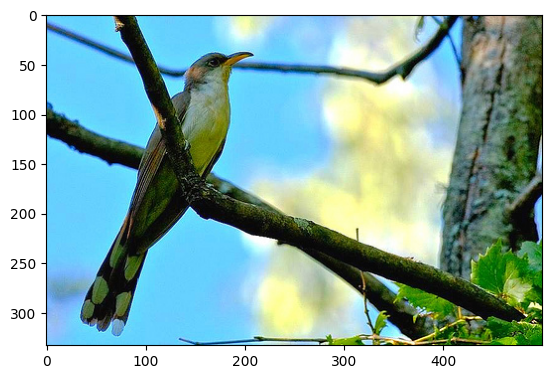

In [7]:
plt.imshow(image.permute(1,2,0))

In [10]:
attributes.size()

torch.Size([112])

In [43]:
import numpy as np

bird_parts =  ["head",
               "beak",
               "tail",
               "wing",
               "leg",
               "eye",
               "torso"]

with open('concepts/CUB/concepts_v4.txt', 'r') as fp:
    original_concepts = fp.read().splitlines()
    unique_concepts = sorted(list(set(original_concepts)))
unique_concepts

original2unique = {}
concept_hierarchy = {}

for cpt in unique_concepts:
    part_category = None
    for part in bird_parts:
        if cpt.endswith(part):
            concept_hierarchy[cpt] = part
concept_hierarchy

{'all-purpose beak': 'beak',
 'black beak': 'beak',
 'black eye': 'eye',
 'black head': 'head',
 'black leg': 'leg',
 'black tail': 'tail',
 'black torso': 'torso',
 'black wing': 'wing',
 'blue head': 'head',
 'brown head': 'head',
 'brown tail': 'tail',
 'brown torso': 'torso',
 'brown wing': 'wing',
 'buff beak': 'beak',
 'buff head': 'head',
 'buff leg': 'leg',
 'buff tail': 'tail',
 'buff torso': 'torso',
 'buff wing': 'wing',
 'cone beak': 'beak',
 'dagger beak': 'beak',
 'duck-like torso': 'torso',
 'eyebrow head': 'head',
 'grey beak': 'beak',
 'grey head': 'head',
 'grey leg': 'leg',
 'grey tail': 'tail',
 'grey torso': 'torso',
 'grey wing': 'wing',
 'hooked seabird beak': 'beak',
 'long beak': 'beak',
 'medium size torso': 'torso',
 'multi-colored tail': 'tail',
 'multi-colored torso': 'torso',
 'multi-colored wing': 'wing',
 'notched tail': 'tail',
 'perching-like torso': 'torso',
 'plain head': 'head',
 'pointed wing': 'wing',
 'rounded wing': 'wing',
 'short beak': 'beak'

In [45]:
for k in concept_hierarchy:
    print(k)

all-purpose beak
black beak
black eye
black head
black leg
black tail
black torso
black wing
blue head
brown head
brown tail
brown torso
brown wing
buff beak
buff head
buff leg
buff tail
buff torso
buff wing
cone beak
dagger beak
duck-like torso
eyebrow head
grey beak
grey head
grey leg
grey tail
grey torso
grey wing
hooked seabird beak
long beak
medium size torso
multi-colored tail
multi-colored torso
multi-colored wing
notched tail
perching-like torso
plain head
pointed wing
rounded wing
short beak
small size torso
solid tail
solid torso
solid wing
spotted wing
striped tail
striped torso
striped wing
very small size torso
white head
white tail
white torso
white wing
yellow head
yellow torso
yellow wing


In [44]:
len(unique_concepts)

57

In [18]:
attributes.numpy()

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [47]:
with open('concepts/CUB/concepts_v4.txt', 'r') as fp:
    original_concepts = fp.read().splitlines()
with open('concepts/CUB/concepts_unique.txt', 'r') as fp:
    unique_concepts = fp.read().splitlines()


original2unique = {}
for i, original_cpt in enumerate(original_concepts):
    original2unique[i] = unique_concepts.index(original_cpt)
original2unique

{0: 20,
 1: 29,
 2: 0,
 3: 19,
 4: 12,
 5: 28,
 6: 56,
 7: 7,
 8: 53,
 9: 18,
 10: 11,
 11: 27,
 12: 55,
 13: 6,
 14: 52,
 15: 17,
 16: 11,
 17: 27,
 18: 55,
 19: 6,
 20: 52,
 21: 17,
 22: 43,
 23: 47,
 24: 33,
 25: 11,
 26: 27,
 27: 55,
 28: 6,
 29: 52,
 30: 17,
 31: 35,
 32: 10,
 33: 26,
 34: 5,
 35: 51,
 36: 16,
 37: 22,
 38: 37,
 39: 11,
 40: 27,
 41: 55,
 42: 6,
 43: 52,
 44: 17,
 45: 24,
 46: 54,
 47: 3,
 48: 50,
 49: 14,
 50: 2,
 51: 30,
 52: 40,
 53: 8,
 54: 9,
 55: 24,
 56: 54,
 57: 3,
 58: 50,
 59: 10,
 60: 26,
 61: 5,
 62: 51,
 63: 16,
 64: 9,
 65: 24,
 66: 54,
 67: 3,
 68: 50,
 69: 14,
 70: 11,
 71: 27,
 72: 55,
 73: 6,
 74: 52,
 75: 17,
 76: 39,
 77: 38,
 78: 41,
 79: 31,
 80: 49,
 81: 21,
 82: 36,
 83: 43,
 84: 47,
 85: 33,
 86: 42,
 87: 46,
 88: 32,
 89: 43,
 90: 11,
 91: 27,
 92: 55,
 93: 6,
 94: 52,
 95: 17,
 96: 25,
 97: 4,
 98: 15,
 99: 23,
 100: 1,
 101: 13,
 102: 8,
 103: 9,
 104: 24,
 105: 54,
 106: 3,
 107: 50,
 108: 44,
 109: 45,
 110: 48,
 111: 34}

In [60]:
idxs, = np.where(attributes.numpy() == 1)

for k, v in original2unique.items():
    idxs[idxs == k] = v

mapped_attr_labels = np.zeros(len(unique_concepts))
mapped_attr_labels[idxs] = 1
mapped_attr_labels

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0.])

In [65]:
expanded = np.stack([mapped_attr_labels]*7)
expanded

array([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
 

In [63]:
import json
with open('concepts/CUB/hierarchy.json') as fp:
    hierarchy = json.load(fp=fp)

bird_parts =  ["head",
               "beak",
               "tail",
               "wing",
               "leg",
               "eye",
               "torso"]

# for cpt in unique_concepts
part_concept_association = np.zeros((len(bird_parts), len(unique_concepts)))
for cpt_idx, cpt in enumerate(unique_concepts):
    part = hierarchy[cpt]
    part_idx = bird_parts.index(part)
    part_concept_association[part_idx, cpt_idx] = 1
part_concept_association.shape
    

(7, 57)

In [64]:
part_concept_association

array([[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
 

In [68]:
part_concept_association.astype(int) & expanded.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 